### Part 1 : Data PreProcessing

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline

In [59]:
# Importing Training Data Set
dataset_train = pd.read_csv('Flood_Data2.csv')

In [60]:
dataset_train.head()

,Date,Flow,405_Martin_Luther_King,410_Lawndale_Street,420_South_Main_Street,430_Stella_Link_Road,440_Rice_Avenue,460_Gessner_Road,465_Beltway_8,470_Belle_Park_Drive,475_Bellaire_Boulevard,485_SH_6
0,1/1/2007 0:00,4.700456,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/1/2007 0:15,4.615508,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/1/2007 0:30,4.388980,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/1/2007 0:45,4.388980,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/1/2007 1:00,4.388980,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Selecting features (columns) to be involved in training and predictions

cols = list(dataset_train)[1:11]

In [62]:
# Extracting dates

datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y %H:%M').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (19566, 12)
All timestamps == 19566
Featured selected: ['Flow', '405_Martin_Luther_King', '410_Lawndale_Street', '420_South_Main_Street', '430_Stella_Link_Road', '440_Rice_Avenue', '460_Gessner_Road', '465_Beltway_8', '470_Belle_Park_Drive', '475_Bellaire_Boulevard']


In [63]:
# converting data to matrix shape format and removing commas

dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple predictors (features)

training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (19566, 10).


array([[4.700456, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [4.615508, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [4.38898 , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [5.6632  , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [5.6632  , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [5.748148, 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [64]:
# Feature Scaling 

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.34532576],
       [-0.34833589],
       [-0.35636289],
       ...,
       [-0.31121099],
       [-0.31121099],
       [-0.30820086]])

In [65]:
# Creating a data structure with 90 timestamps and 1 output

X_train = []
y_train = []

n_future = 60  # number of days we want to predict into the future
n_past = 90 # number of past days we want to use to predict the future 

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}'.format(X_train.shape))
print('y_train shape == {}'.format(y_train.shape))


X_train shape == (19417, 90, 9)
y_train shape == (19417, 0)


### Part 2 Creating a Model , Training

In [66]:
# Building the LSTM based Neural Network

In [67]:
#Importing Packages and Libraries from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [68]:
# Intitializing the neural network based on LSTM

model = Sequential()

In [69]:
# Adding 1st LSTM layer

model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer

model.add(LSTM(units=10, return_sequences=False))

# Adding dropout

model.add(Dropout(0.25))

# Output layer 
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [70]:
# Start Training

In [71]:
%%time

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')
history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: nan
Epoch 1: val_loss did not improve from inf
61/61 [==============================] - 25s 328ms/step - loss: nan - val_loss: nan - lr: 0.0100
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: nan
Epoch 2: val_loss did not improve from inf
61/61 [==============================] - 16s 259ms/step - loss: nan - val_loss: nan - lr: 0.0100
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: nan
Epoch 3: val_loss did not improve from inf
61/61 [==============================] - 19s 311ms/step - loss: nan - val_loss: nan - lr: 0.0100
Epoch 4/30
61/61 [==============================] - ETA: 0s - loss: nan
Epoch 4: val_loss did not improve from inf
61/61 [==============================] - 21s 337ms/step - loss: nan - val_loss: nan - lr: 0.0100
Epoch 5/30
61/61 [==============================] - ETA: 0s - loss: nan
Epoch 5: val_loss did not improve from inf
61/61 [==============================

### Part 3:

In [72]:
#Step 5: Make predictions for future dates

In [73]:
# Generate list of sequence of days for predictions

datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE

datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [74]:
# Perform Prediction

predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

604/604 [==============================] - 18s 29ms/step


In [75]:
# Inverse the predictions to orginial measurements

# special function convert <datetime.date> to <Timestamp>

def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%m/%d/%Y %H:%M'), '%m/%d/%Y %H:%M')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train) 

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Flow']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Flow']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <TimeStamp> for Predition_Train

PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head()

,Flow
2007-01-03,15.695378
2007-01-03,15.695052
2007-01-03,15.694824
2007-01-03,15.694048
2007-01-03,15.693092


In [76]:
# Step 6 : Visualize the Predictions

In [77]:
# Parse training set timestamp for better visualization

dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

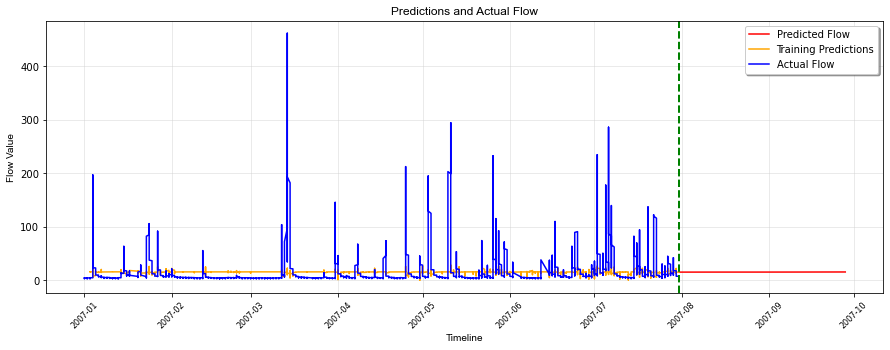

In [85]:
# Set Plot Size

from pylab import rcParams
rcParams['figure.figsize'] = 15,5

# Plot Parameters

START_DATE_FOR_PLOTTING = '2007-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Flow'], color='r', label= 'Predicted Flow')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Flow'], color='orange', label='Training Predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Flow'], color='b', label='Actual Flow')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Flow', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Flow Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [79]:
from sklearn.metrics import mean_squared_error

In [80]:
from math import sqrt 

In [81]:
#Evaluating the model, Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_pred_train, predictions_train))
print('RMSE: %.3f' % rmse)

RMSE: 15.059
